In [ ]:
# === 1. Dowloanding libraries
!pip install opencv-python scikit-image matplotlib numpy ipywidgets pandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [ ]:
# === 2. import of libs ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
from google.colab import files
from IPython.display import display, HTML
import ipywidgets as widgets
import pandas as pd

In [ ]:
# === 3.Image impoting ===
uploaded = files.upload()
if not uploaded:
    raise FileNotFoundError("❌ No file uploaded. Please upload your image.")

image_path = next(iter(uploaded))

original = cv2.imread(image_path)
if original is None:
    raise FileNotFoundError("❌ Failed to load image.")

Saving Normal-19.png to Normal-19.png


In [ ]:
# === 4. grayscaling and image resize ===
gray = cv2.cvtColor(cv2.resize(original, (224, 224)), cv2.COLOR_BGR2GRAY)

In [ ]:
# === 5. Widgets
d_slider = widgets.IntSlider(value=5, min=1, max=15, step=2, description='🧼 Bilateral d')
sigmaColor_slider = widgets.IntSlider(value=30, min=10, max=100, step=10, description='🎨 σColor')
clipLimit_slider = widgets.FloatSlider(value=1.5, min=1.0, max=3.0, step=0.1, description='⚡ CLAHE')
sharpen_slider = widgets.FloatSlider(value=3.0, min=2.0, max=5.0, step=0.1, description='🔪 Sharpness')
save_button = widgets.Button(description="💾 Save enhanced image", button_style='success')

In [ ]:

# === 6. Image pre-processing

last_enhanced = None  # to save result
def process_image(d, sigmaColor, clipLimit, sharpness):
    global last_enhanced
    #Noise reduction
    denoised = cv2.bilateralFilter(gray, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaColor)

    # Contrast
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    # Sharpness
    kernel_sharpen = np.array([[0, -0.5, 0],
                               [-0.5, sharpness, -0.5],
                               [0, -0.5, 0]])
    sharpened = cv2.filter2D(contrast, -1, kernel_sharpen)

    # Normalization
    enhanced = cv2.normalize(sharpened, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    last_enhanced = enhanced

    # SSIM metrics and Brightness
    ssim_score = ssim(gray, enhanced)
    brightness_before = np.mean(gray)
    brightness_after = np.mean(enhanced)

    # === Vizualization ===
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title(f"Enhanced (SSIM={ssim_score:.3f})")
    plt.axis('off')
    plt.show()

    print(f"✅ SSIM (before vs after): {ssim_score:.4f}")
    print(f"💡 Mean Brightness Before: {brightness_before:.2f}")
    print(f"💡 Mean Brightness After:  {brightness_after:.2f}")

    # === Подсказки о параметрах ===
    hints = []
    if clipLimit > 2.5:
        hints.append("⚠️ Контраст слишком высокий — может появиться зернистость.")
    if sharpness > 4.5:
        hints.append("⚠️ Резкость чрезмерна — возможны артефакты на границах.")
    if sigmaColor > 80:
        hints.append("ℹ️ Изображение может стать слишком мягким из-за сильного сглаживания.")
    if not hints:
        hints.append("✅ Параметры сбалансированы. Хорошая основа для анализа.")
    for h in hints:
        print(h)

In [ ]:
# button to save image
def save_image(_):
    if last_enhanced is not None:
        filename = "enhanced_image.png"
        cv2.imwrite(filename, last_enhanced)
        print(f"💾 Image saved as '{filename}'")
    else:
        print("❌ Please process the image first before saving.")

save_button.on_click(save_image)

In [ ]:
#recommendations
data = {
     "Parameter": ["Bilateral d", "σColor", "CLAHE (clipLimit)", "Sharpness"],
     "Range": ["3–9", "20–80", "1.2–2.5", "2.5–4.0"],
     "Effect with increase":
      [ "Stronger smoothing (less noise, but less detail)",
       "Softer image",
       "Higher contrast, but graininess may appear.",
       "Sharper borders, risk of overexposure" ]
}
table = pd.DataFrame(data)
display(HTML("<h3>📊 Recommendations for parameters</h3>"))
display(table)

,Parameter,Range,Effect with increase
0,Bilateral d,3–9,"Stronger smoothing (less noise, but less detail)"
1,σColor,20–80,Softer image
2,CLAHE (clipLimit),1.2–2.5,"Higher contrast, but graininess may appear."
3,Sharpness,2.5–4.0,"Sharper borders, risk of overexposure"


In [ ]:
#interactive for widget

display(widgets.interact(process_image,
                         d=d_slider,
                         sigmaColor=sigmaColor_slider,
                         clipLimit=clipLimit_slider,
                         sharpness=sharpen_slider),
         save_button)

interactive(children=(IntSlider(value=5, description='🧼 Bilateral d', max=15, min=1, step=2), IntSlider(value=…

<function __main__.process_image(d, sigmaColor, clipLimit, sharpness)>

Button(button_style='success', description='💾 Save enhanced image', style=ButtonStyle())

## Automated process of cleaning images

In [1]:
import os
import zipfile
import random
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from google.colab import drive

# =============================
# Настройки
# =============================
CATEGORY_NAME = "COVID"  # Меняй на "normal"
ZIP_GDRIVE_PATH = "/content/drive/MyDrive/COVID.zip"  # путь к ZIP в твоем Google Drive
COUNT_TO_SELECT = 3000

# Монтируем Google Drive
drive.mount('/content/drive')

# Пути
unzipped_folder = f"/content/drive/MyDrive/{CATEGORY_NAME}_unzipped"
output_folder = f"/content/drive/MyDrive/enhanced_{CATEGORY_NAME}"
os.makedirs(unzipped_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# =============================
# Функции обработки
# =============================
def auto_denoise(image):
    gauss = cv2.GaussianBlur(image, (3, 3), 0)
    diff = cv2.absdiff(image, gauss)
    noise_sigma = np.std(diff)

    if noise_sigma < 10:
        return cv2.GaussianBlur(image, (3, 3), 0)
    elif noise_sigma < 20:
        return cv2.medianBlur(image, 3)
    else:
        return cv2.bilateralFilter(image, d=5, sigmaColor=50, sigmaSpace=50)


def enhance_image(gray):
    denoised = auto_denoise(gray)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    kernel_sharp = np.array([
        [0, -0.5, 0],
        [-0.5, 3.0, -0.5],
        [0, -0.5, 0]
    ])
    sharp = cv2.filter2D(contrast, -1, kernel_sharp)

    return cv2.normalize(sharp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# =============================
# Распаковка
# =============================
print("Распаковка ZIP...")
with zipfile.ZipFile(ZIP_GDRIVE_PATH, 'r') as zip_ref:
    zip_ref.extractall(unzipped_folder)
print(f"Файлы разархивированы в: {unzipped_folder}")

# =============================
# Поиск изображений
# =============================
print("Сканирование...")
all_files = []
for root, dirs, files in os.walk(unzipped_folder):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_files.append(os.path.join(root, f))

print(f"Найдено: {len(all_files)} файлов")
selected = all_files if len(all_files) < COUNT_TO_SELECT else random.sample(all_files, COUNT_TO_SELECT)
print(f"Будет обработано: {len(selected)}")

# =============================
# Обработка
# =============================
results = []

for i, path in enumerate(selected):
    img = cv2.imread(path)
    if img is None:
        continue

    gray = cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_BGR2GRAY)
    enhanced = enhance_image(gray)

    out_name = f"{CATEGORY_NAME}_{i}.jpg"
    cv2.imwrite(os.path.join(output_folder, out_name), enhanced)

    results.append({
        "filename": out_name,
        "ssim": ssim(gray, enhanced),
        "brightness_before": np.mean(gray),
        "brightness_after": np.mean(enhanced),
    })

    if i % 200 == 0:
        print(f"{i}/{len(selected)}...")

# =============================
# CSV
# =============================
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_folder, "report.csv"), index=False)

print("Готово!")
print(f"Папка с разархивированными файлами: {unzipped_folder}")
print(f"Папка с обработанными файлами: {output_folder}")
print(f"CSV сохранён: {os.path.join(output_folder, 'report.csv')}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Распаковка ZIP...
Файлы разархивированы в: /content/drive/MyDrive/COVID_unzipped
Сканирование...
Найдено: 3616 файлов
Будет обработано: 3000
0/3000...
200/3000...
400/3000...
600/3000...
800/3000...
1000/3000...
1200/3000...
1400/3000...
1600/3000...
1800/3000...
2000/3000...
2200/3000...
2400/3000...
2600/3000...
2800/3000...
Готово!
Папка с разархивированными файлами: /content/drive/MyDrive/COVID_unzipped
Папка с обработанными файлами: /content/drive/MyDrive/enhanced_COVID
CSV сохранён: /content/drive/MyDrive/enhanced_COVID/report.csv


Same code but for enhancing normal images


In [2]:
import os
import zipfile
import random
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from google.colab import drive

# =============================
# Настройки
# =============================
CATEGORY_NAME = "normal"  # Меняй на "normal"
ZIP_GDRIVE_PATH = "/content/drive/MyDrive/normal.zip"  # путь к ZIP в твоем Google Drive
COUNT_TO_SELECT = 3000

# Монтируем Google Drive
drive.mount('/content/drive')

# Пути
unzipped_folder = f"/content/drive/MyDrive/{CATEGORY_NAME}_unzipped"
output_folder = f"/content/drive/MyDrive/enhanced_{CATEGORY_NAME}"
os.makedirs(unzipped_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# =============================
# Функции обработки
# =============================
def auto_denoise(image):
    gauss = cv2.GaussianBlur(image, (3, 3), 0)
    diff = cv2.absdiff(image, gauss)
    noise_sigma = np.std(diff)

    if noise_sigma < 10:
        return cv2.GaussianBlur(image, (3, 3), 0)
    elif noise_sigma < 20:
        return cv2.medianBlur(image, 3)
    else:
        return cv2.bilateralFilter(image, d=5, sigmaColor=50, sigmaSpace=50)


def enhance_image(gray):
    denoised = auto_denoise(gray)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    kernel_sharp = np.array([
        [0, -0.5, 0],
        [-0.5, 3.0, -0.5],
        [0, -0.5, 0]
    ])
    sharp = cv2.filter2D(contrast, -1, kernel_sharp)

    return cv2.normalize(sharp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# =============================
# Распаковка
# =============================
print("Распаковка ZIP...")
with zipfile.ZipFile(ZIP_GDRIVE_PATH, 'r') as zip_ref:
    zip_ref.extractall(unzipped_folder)
print(f"Файлы разархивированы в: {unzipped_folder}")

# =============================
# Поиск изображений
# =============================
print("Сканирование...")
all_files = []
for root, dirs, files in os.walk(unzipped_folder):
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_files.append(os.path.join(root, f))

print(f"Найдено: {len(all_files)} файлов")
selected = all_files if len(all_files) < COUNT_TO_SELECT else random.sample(all_files, COUNT_TO_SELECT)
print(f"Будет обработано: {len(selected)}")

# =============================
# Обработка
# =============================
results = []

for i, path in enumerate(selected):
    img = cv2.imread(path)
    if img is None:
        continue

    gray = cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_BGR2GRAY)
    enhanced = enhance_image(gray)

    out_name = f"{CATEGORY_NAME}_{i}.jpg"
    cv2.imwrite(os.path.join(output_folder, out_name), enhanced)

    results.append({
        "filename": out_name,
        "ssim": ssim(gray, enhanced),
        "brightness_before": np.mean(gray),
        "brightness_after": np.mean(enhanced),
    })

    if i % 200 == 0:
        print(f"{i}/{len(selected)}...")

# =============================
# CSV
# =============================
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_folder, "report.csv"), index=False)

print("Готово!")
print(f"Папка с разархивированными файлами: {unzipped_folder}")
print(f"Папка с обработанными файлами: {output_folder}")
print(f"CSV сохранён: {os.path.join(output_folder, 'report.csv')}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Распаковка ZIP...
Файлы разархивированы в: /content/drive/MyDrive/normal_unzipped
Сканирование...
Найдено: 3000 файлов
Будет обработано: 3000
0/3000...
200/3000...
400/3000...
600/3000...
800/3000...
1000/3000...
1200/3000...
1400/3000...
1600/3000...
1800/3000...
2000/3000...
2200/3000...
2400/3000...
2600/3000...
2800/3000...
Готово!
Папка с разархивированными файлами: /content/drive/MyDrive/normal_unzipped
Папка с обработанными файлами: /content/drive/MyDrive/enhanced_normal
CSV сохранён: /content/drive/MyDrive/enhanced_normal/report.csv


ПРОСТО ДЛЯ ПЕРЕМЕЧЕНИЯ Если загрузили в другую папку


In [3]:
import os
import shutil

src = "/content/drive/MyDrive/COVID_unzipped/COVID"
dst = "/content/COVID"

os.makedirs(dst, exist_ok=True)

for root, dirs, files in os.walk(src):
    for f in files:
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            shutil.move(os.path.join(root, f), os.path.join(dst, f))


In [4]:
import os
import shutil

src = "/content/drive/MyDrive/normal_unzipped/Selected_normal"
dst = "/content/normal"

os.makedirs(dst, exist_ok=True)

for root, dirs, files in os.walk(src):
    for f in files:
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            shutil.move(os.path.join(root, f), os.path.join(dst, f))


In [5]:
import os
import shutil

src = "/content/drive/MyDrive/enhanced_COVID"
dst = "/content/enhanced_COVID"

os.makedirs(dst, exist_ok=True)

for root, dirs, files in os.walk(src):
    for f in files:
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            shutil.move(os.path.join(root, f), os.path.join(dst, f))


In [6]:
import os
import shutil

src = "/content/drive/MyDrive/enhanced_normal"
dst = "/content/enhanced_normal"

os.makedirs(dst, exist_ok=True)

for root, dirs, files in os.walk(src):
    for f in files:
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            shutil.move(os.path.join(root, f), os.path.join(dst, f))


# Training the model Convolutional neural network

Found 5293 images belonging to 2 classes.
Found 1323 images belonging to 2 classes.
Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


331/331 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.7006 - loss: 0.6859 - val_accuracy: 0.8073 - val_loss: 0.4574
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.8681 - loss: 0.3226 - val_accuracy: 0.8934 - val_loss: 0.2593
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9204 - loss: 0.2219 - val_accuracy: 0.8730 - val_loss: 0.3466
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9442 - loss: 0.1653 - val_accuracy: 0.9101 - val_loss: 0.2404
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9534 - loss: 0.1334 - val_accuracy: 0.9221 - val_loss: 0.2472
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9656 - loss: 0.0973 - val_accuracy: 0.9206 - val_loss: 0.2524
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9791 - loss: 0.0655 - val_accuracy: 0.9252 - val_loss: 0.2545
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9789 - loss: 0.0579 - val_accurac

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


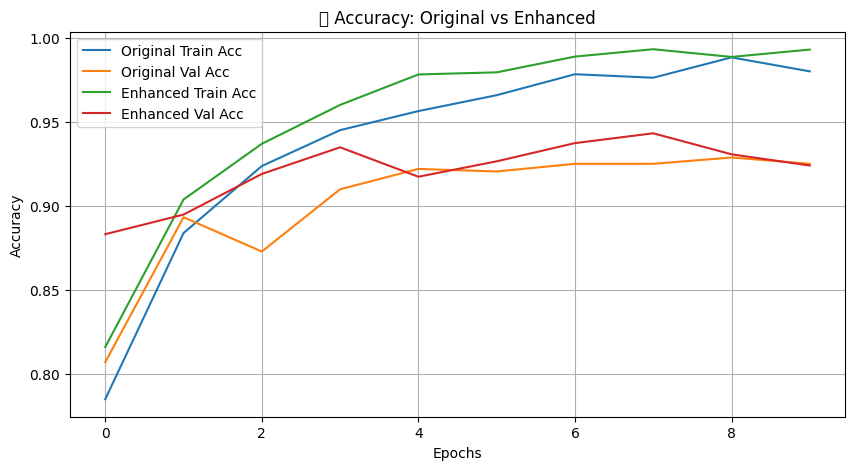

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH = 16

# Создаем датагенератор
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --- 1. Оригинальный датасет ---
train_original = datagen.flow_from_directory(
    directory="/content", # Исправлено: путь к родительской папке с классами
    classes=["normal", "COVID"],  # Обновлено: указываем папку с перемещенными COVID изображениями
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='training'
)

val_original = datagen.flow_from_directory(
    directory="/content", # Исправлено: путь к родительской папке с классами
    classes=["normal", "COVID"],  # Обновлено: указываем папку с перемещенными COVID изображениями
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='validation'
)

# --- 2. Улучшенный датасет ---
# Внимание: папка "enhanced_covid2auto" не существует. Это вызовет ошибку.
# Вам необходимо либо создать эту папку и поместить туда обработанные изображения COVID,
# либо скорректировать этот блок кода.
train_enhanced = datagen.flow_from_directory(
    directory="/content", # Исправлено: путь к родительской папке с классами
    classes=["enhanced_normal", "enhanced_COVID"],  # папки с улучшенными изображениями
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='training'
)

val_enhanced = datagen.flow_from_directory(
    directory="/content", # Исправлено: путь к родительской папке с классами
    classes=["enhanced_normal", "enhanced_COVID"],
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='validation'
)
#conventional neural newtork
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_original = build_model()

history_original = model_original.fit(
    train_original,
    validation_data=val_original,
    epochs=10
)

model_enhanced = build_model()

history_enhanced = model_enhanced.fit(
    train_enhanced,
    validation_data=val_enhanced,
    epochs=10
)

plt.figure(figsize=(10,5))

# Original
plt.plot(history_original.history['accuracy'], label='Original Train Acc')
plt.plot(history_original.history['val_accuracy'], label='Original Val Acc')

# Enhanced
plt.plot(history_enhanced.history['accuracy'], label='Enhanced Train Acc')
plt.plot(history_enhanced.history['val_accuracy'], label='Enhanced Val Acc')

plt.title("📈 Accuracy: Original vs Enhanced")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# EfficientNetB0

Class weights: {0: np.float64(0.953514739229025), 1: np.float64(1.05125)}
Found 10092 validated image filenames belonging to 2 classes.
Found 2524 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 195s 276ms/step - accuracy: 0.5032 - loss: 0.7009 - val_accuracy: 0.5243 - val_loss: 0.6919
Epoch 2/10
  1/630 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5000 - loss: 0.6980

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


630/630 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5000 - loss: 0.6980 - val_accuracy: 0.5243 - val_loss: 0.6919
Epoch 3/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 153s 243ms/step - accuracy: 0.4990 - loss: 0.6996 - val_accuracy: 0.5243 - val_loss: 0.6922
Epoch 4/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5000 - loss: 0.7057 - val_accuracy: 0.5243 - val_loss: 0.6923
Epoch 5/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 154s 245ms/step - accuracy: 0.5061 - loss: 0.6959 - val_accuracy: 0.4757 - val_loss: 0.6965
Epoch 6/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4375 - loss: 0.7021 - val_accuracy: 0.4757 - val_loss: 0.6966
Epoch 7/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 155s 245ms/step - accuracy: 0.4927 - loss: 0.6986 - val_accuracy: 0.5243 - val_loss: 0.6926
Epoch 8/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3125 - loss: 0.7374 - val_accuracy: 0.5243 - val_loss: 0.6926
Epoch 9/10
630/630 ━━━━━━━━━━━━━━━━━━━━ 152s 241ms/step - accuracy: 0.5156 - loss: 0.6945 - val_accu

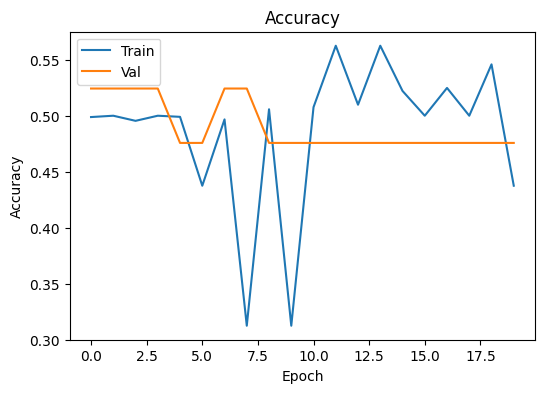

🎉 Обучение завершено!


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# --------------------------------------------------------
# Настройки
# --------------------------------------------------------
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_TOP = 10
EPOCHS_FINE = 10
LEARNING_RATE_FINE = 1e-5

# Пути к папкам с изображениями
paths = {
    "COVID": "/content/COVID",
    "Normal": "/content/normal",
    "enhanced_COVID": "/content/enhanced_COVID",
    "enhanced_Normal": "/content/enhanced_normal"
}

# --------------------------------------------------------
# Создание DataFrame с файлами и метками
# --------------------------------------------------------
file_paths = []
labels = []

for label_name, folder in paths.items():
    class_label = "COVID" if "COVID" in label_name else "Normal"
    for f in os.listdir(folder):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(folder, f))
            labels.append(class_label)

df = pd.DataFrame({"filename": file_paths, "class": labels})

# --------------------------------------------------------
# Split train / validation
# --------------------------------------------------------
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# --------------------------------------------------------
# Вычисляем class_weight
# --------------------------------------------------------
classes = train_df['class'].map({'COVID':0, 'Normal':1}).values
weights = class_weight.compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

# --------------------------------------------------------
# Аугментации
# --------------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7,1.3],
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    channel_shift_range=20.0,  # добавляем цветовой шум
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --------------------------------------------------------
# Создание модели EfficientNetB0
# --------------------------------------------------------
def build_efficientnet():
    base = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# --------------------------------------------------------
# Этап 1: обучение верхних слоев
# --------------------------------------------------------
steps_train = len(train_df) // BATCH_SIZE
steps_val = len(val_df) // BATCH_SIZE

model = build_efficientnet()
history_top = model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_TOP,
    class_weight=class_weights
)

# --------------------------------------------------------
# Этап 2: Fine-tuning
# --------------------------------------------------------
# Разморозим последние 50 слоев EfficientNet
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE_FINE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_FINE,
    class_weight=class_weights
)

# --------------------------------------------------------
# График обучения
# --------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history_top.history['accuracy'] + history_fine.history['accuracy'], label='Train')
plt.plot(history_top.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("🎉 Обучение завершено!")


In [3]:
model.save("/content/drive/MyDrive/models_xray/efficientnetb0_model.h5")
print("Модель сохранена в формате .h5")

# 2) Формат TensorFlow SavedModel
model.save("/content/drive/MyDrive/models_xray/efficientnetb0.keras")




Модель сохранена в формате .h5


# dRAWING CONFUSION MATRIX

83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step


<Figure size 500x500 with 0 Axes>

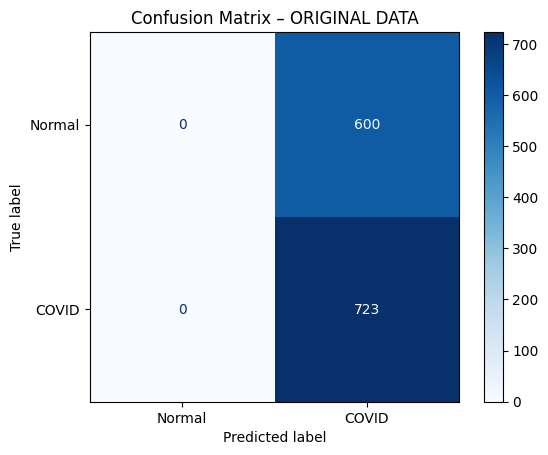

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


<Figure size 500x500 with 0 Axes>

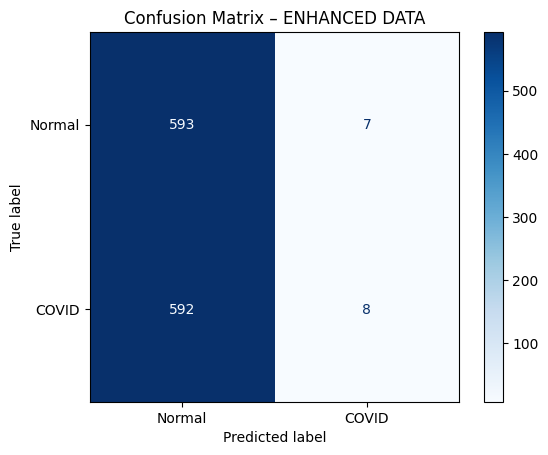

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix(model, generator, title):
    # Получаем реальные классы
    true_labels = generator.classes

    # Предсказания модели
    preds = model.predict(generator)
    preds = (preds > 0.5).astype(int)

    # Строим confusion matrix
    cm = confusion_matrix(true_labels, preds)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Normal", "COVID"]
    )

    plt.figure(figsize=(5,5))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(title)
    plt.show()

# ----------------------------------------
# Confusion Matrix для обеих моделей
# ----------------------------------------

plot_conf_matrix(model_original, val_original, "Confusion Matrix – ORIGINAL DATA")
plot_conf_matrix(model_enhanced, val_enhanced, "Confusion Matrix – ENHANCED DATA")


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, generator):
    true = generator.classes
    preds = (model.predict(generator) > 0.5).astype(int)

    return {
        "Accuracy": accuracy_score(true, preds),
        "Precision": precision_score(true, preds),
        "Recall": recall_score(true, preds),
        "F1-score": f1_score(true, preds)
    }

# Получаем метрики
original_metrics = evaluate_model(model_original, val_original)
enhanced_metrics = evaluate_model(model_enhanced, val_enhanced)

# Создаём таблицу
df = pd.DataFrame({
    "Original Data": original_metrics,
    "Enhanced Data": enhanced_metrics
})

print(df)
df


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
           Original Data  Enhanced Data
Accuracy        0.546485       0.499167
Precision       0.546485       0.466667
Recall          1.000000       0.011667
F1-score        0.706745       0.022764


,Original Data,Enhanced Data
Accuracy,0.546485,0.499167
Precision,0.546485,0.466667
Recall,1.000000,0.011667
F1-score,0.706745,0.022764


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


,Original Data,Enhanced Data
Accuracy,0.546485,0.499167
Precision,0.546485,0.466667
Recall,1.000000,0.011667
F1-score,0.706745,0.022764


📁 Saved: metrics_comparison.csv


<Figure size 800x500 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


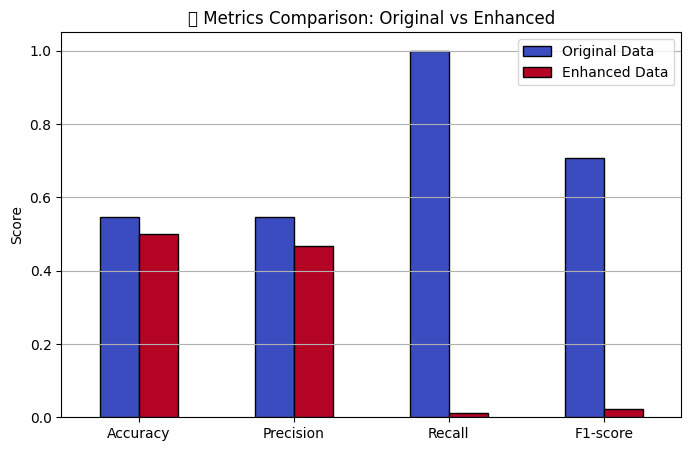

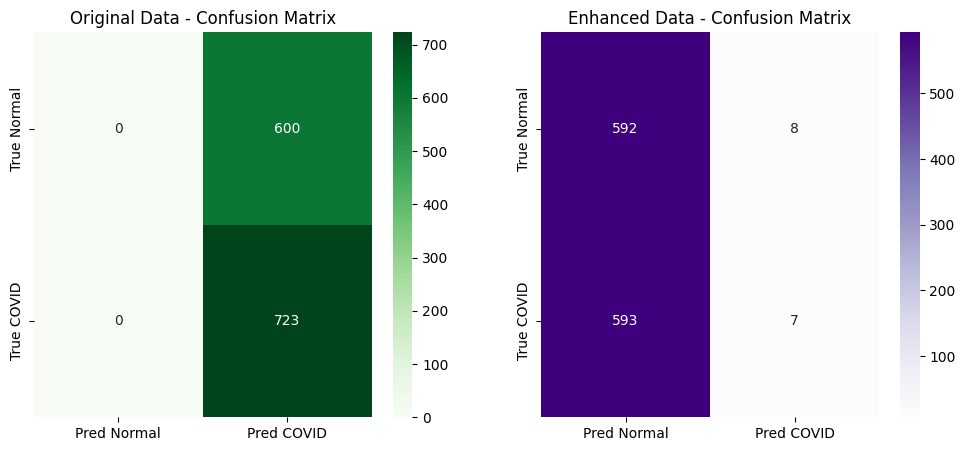

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === PREDICTIONS ===
def get_metrics(model, generator):
    y_true = generator.classes
    y_pred = (model.predict(generator) > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    return acc, prec, rec, f1, cm

# === Original data metrics ===
acc_o, prec_o, rec_o, f1_o, cm_o = get_metrics(model_original, val_original)

# === Enhanced data metrics ===
acc_e, prec_e, rec_e, f1_e, cm_e = get_metrics(model_enhanced, val_enhanced)

# === Summary table ===
df = pd.DataFrame({
    "Original Data": [acc_o, prec_o, rec_o, f1_o],
    "Enhanced Data": [acc_e, prec_e, rec_e, f1_e]
}, index=["Accuracy", "Precision", "Recall", "F1-score"])

display(df.style.background_gradient(cmap="Blues"))

# === Save CSV ===
df.to_csv("metrics_comparison.csv")
print("📁 Saved: metrics_comparison.csv")

# === BAR CHART ===
plt.figure(figsize=(8,5))
df.plot(kind='bar', figsize=(8,5), colormap='coolwarm', edgecolor='black')
plt.title("📊 Metrics Comparison: Original vs Enhanced")
plt.ylabel("Score")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

# === CONFUSION MATRIX HEATMAPS ===
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_o, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Pred Normal", "Pred COVID"],
            yticklabels=["True Normal", "True COVID"],
            ax=axs[0])
axs[0].set_title("Original Data - Confusion Matrix")

sns.heatmap(cm_e, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred Normal", "Pred COVID"],
            yticklabels=["True Normal", "True COVID"],
            ax=axs[1])
axs[1].set_title("Enhanced Data - Confusion Matrix")

plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    directory="/content/",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=["normal", "COVID"],
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    directory="/content/",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=["normal", "COVID"],
    class_mode='binary',
    subset='validation'
)

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[es])

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend()
plt.show()


Found 5293 images belonging to 2 classes.
Found 1323 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 143s 378ms/step - accuracy: 0.7438 - loss: 0.4991 - val_accuracy: 0.8828 - val_loss: 0.2850
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 99s 300ms/step - accuracy: 0.8316 - loss: 0.3640 - val_accuracy: 0.8866 - val_loss: 0.2730
Epoch 3/10
 34/331 ━━━━━━━━━━━━━━━━━━━━ 1:02 212ms/step - accuracy: 0.8527 - loss: 0.3561

KeyboardInterrupt: 

Epoch 1/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5958 - loss: 0.6825 - val_accuracy: 0.7954 - val_loss: 0.4510
Epoch 2/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.7886 - loss: 0.4528 - val_accuracy: 0.8284 - val_loss: 0.3954
Epoch 3/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.8184 - loss: 0.3935 - val_accuracy: 0.8412 - val_loss: 0.3614
Epoch 4/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8400 - loss: 0.3597 - val_accuracy: 0.8469 - val_loss: 0.3413
Epoch 5/5
630/630 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.8456 - loss: 0.3522 - val_accuracy: 0.8553 - val_loss: 0.3257
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step
Accuracy: 0.8538034865293186
Precision: 0.8609221466364324
Recall: 0.8602719033232629
F1-score: 0.8605969021533811


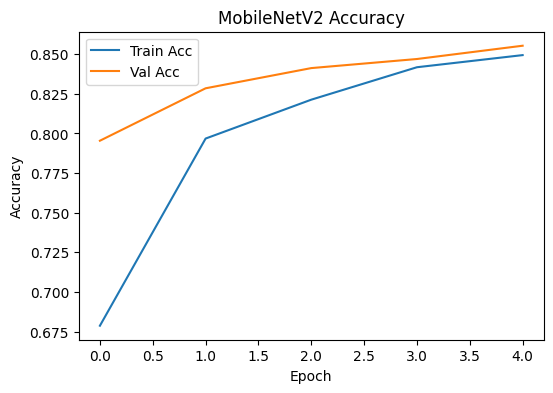

In [18]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# ---------------------------
# Настройки
# ---------------------------
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5  # можно увеличить
RANDOM_SEED = 42

# Пути к папкам с изображениями
original_covid = "/content/COVID"
original_normal = "/content/normal"
enhanced_covid = "/content/enhanced_COVID"
enhanced_normal = "/content/enhanced_normal"

# ---------------------------
# Сбор файлов и меток
# ---------------------------
def load_files(paths, label):
    files = []
    labels = []
    for path in paths:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(os.path.join(path, f))
                labels.append(label)
    return files, labels

files_covid, labels_covid = load_files([original_covid, enhanced_covid], 1)
files_normal, labels_normal = load_files([original_normal, enhanced_normal], 0)

all_files = files_covid + files_normal
all_labels = labels_covid + labels_normal

# Перемешиваем
combined = list(zip(all_files, all_labels))
random.seed(RANDOM_SEED)
random.shuffle(combined)
all_files, all_labels = zip(*combined)

# ---------------------------
# Train / Validation split
# ---------------------------
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=all_labels
)

# ---------------------------
# Генератор данных
# ---------------------------
def data_generator(files, labels, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
    n = len(files)
    indices = np.arange(n)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            batch_images = []
            batch_labels = []
            for i in batch_indices:
                img = cv2.imread(files[i])
                if img is None:
                    continue
                img = cv2.cvtColor(cv2.resize(img, (img_size, img_size)), cv2.COLOR_BGR2RGB)
                img = img / 255.0
                batch_images.append(img)
                batch_labels.append(labels[i])
            if batch_images:
                yield np.array(batch_images), np.array(batch_labels)

train_gen = data_generator(train_files, train_labels, batch_size=BATCH_SIZE)
val_gen = data_generator(val_files, val_labels, batch_size=BATCH_SIZE)

steps_per_epoch = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE

# ---------------------------
# Создание модели MobileNetV2
# ---------------------------
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ---------------------------
# Обучение
# ---------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

# ---------------------------
# Метрики на валидном наборе
# ---------------------------
# Загружаем все изображения для метрик
def load_images(files, labels, img_size=IMG_SIZE):
    images = []
    valid_labels = []
    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            continue
        img = cv2.cvtColor(cv2.resize(img, (img_size, img_size)), cv2.COLOR_BGR2RGB)
        img = img / 255.0
        images.append(img)
        valid_labels.append(labels[i])
    return np.array(images), np.array(valid_labels)

val_images, val_labels_array = load_images(val_files, val_labels)

y_pred = (model.predict(val_images, batch_size=BATCH_SIZE) > 0.5).astype(int).reshape(-1)

print("Accuracy:", accuracy_score(val_labels_array, y_pred))
print("Precision:", precision_score(val_labels_array, y_pred))
print("Recall:", recall_score(val_labels_array, y_pred))
print("F1-score:", f1_score(val_labels_array, y_pred))

# ---------------------------
# График обучения
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Accuracy')
plt.legend()
plt.show()


In [5]:
!mkdir -p /content/drive/MyDrive/models_xray

# Correcting the first save call to include a .keras extension
model.save('/content/drive/MyDrive/models_xray/mobilenetv2_xray.keras')
model.save('/content/drive/MyDrive/models_xray/mobilenetv2_xray.h5')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd
import tensorflow as tf

# ---------------- Настройки ----------------
SAVE_DIR = "/content/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH = 32

import numpy as np

X_list, y_list = [], []

# Предположим, val_gen — это твой генератор
for batch_x, batch_y in val_gen:
    X_list.append(batch_x)
    y_list.append(batch_y)

X_val = np.concatenate(X_list, axis=0)
y_true = np.concatenate(y_list, axis=0)

# Если метки one-hot
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# Предсказания модели
y_scores = model.predict(X_val).ravel()
y_pred = (y_scores > 0.5).astype(int)


# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","COVID"], yticklabels=["Normal","COVID"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), dpi=150)
plt.show()

# ---------------- Classification Report ----------------
report = classification_report(y_true, y_pred, target_names=["Normal","COVID"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(SAVE_DIR, "classification_report.csv"), index=True)
print("Classification report saved to:", os.path.join(SAVE_DIR, "classification_report.csv"))

# ---------------- ROC Curve ----------------
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "roc_curve.png"), dpi=150)
plt.show()

# ---------------- Precision-Recall Curve ----------------
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_prec = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_prec:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "pr_curve.png"), dpi=150)
plt.show()

print(f"ROC AUC: {roc_auc:.4f}, Average Precision: {avg_prec:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded model from /content/drive/MyDrive/models_xray/mobilenetv2_xray.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step


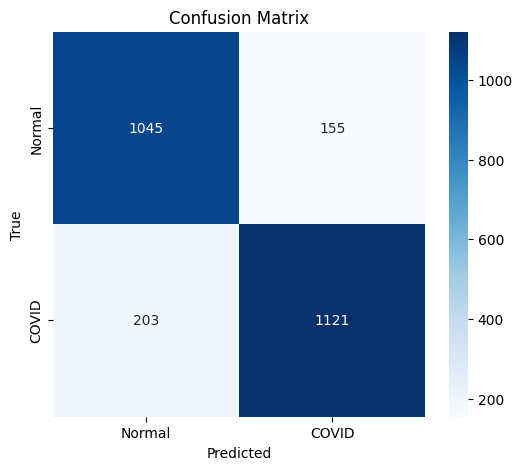

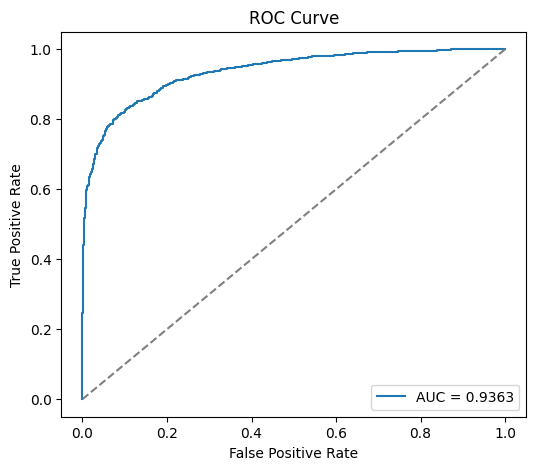

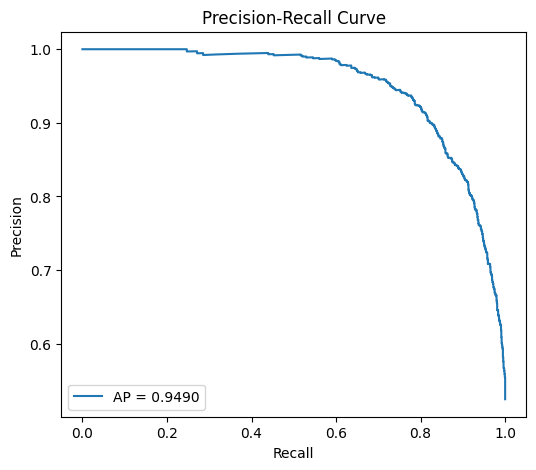

Classification report saved to: /content/visualizations/classification_report.csv
Confusion matrix:
 [[1045  155]
 [ 203 1121]]
ROC AUC: 0.9363135699899294
Average precision: 0.9489684110037485
Skipping example 0 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Skipping example 1 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Skipping example 2 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Skipping example 3 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Skipping example 4 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Skipping example 5 due to Grad-CAM error: Gradients for layer 'Conv_1' are None. Check model graph and tape watching.
Saved 6 examples to /content/visualizations/false_negatives
Skipping example 0 due to Grad-CAM err

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd
import tensorflow as tf
import cv2 # Ensure cv2 is imported
import random
from sklearn.model_selection import train_test_split

# Check if 'model' is defined, if not, load it
if 'model' not in locals():
    try:
        model = tf.keras.models.load_model('/content/drive/MyDrive/models_xray/mobilenetv2_xray.keras')
        print("Loaded model from /content/drive/MyDrive/models_xray/mobilenetv2_xray.keras")
    except Exception as e:
        print(f"Error loading model: {e}. Please ensure cell QBAf4CJhpX4D was run or the model is correctly saved.")

# Parameters
IMG_SIZE = 224 # Make sure IMG_SIZE is defined for the Input layer
SAVE_DIR = "/content/visualizations"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH = 32
RANDOM_SEED = 42

# Paths to image folders (copied from QBAf4CJhpX4D)
original_covid = "/content/COVID"
original_normal = "/content/normal"
enhanced_covid = "/content/enhanced_COVID"
enhanced_normal = "/content/enhanced_normal"

# ---------------------------
# Сбор файлов и меток (copied from QBAf4CJhpX4D)
# ---------------------------
def load_files(paths, label):
    files = []
    labels = []
    for path in paths:
        if not os.path.exists(path):
            print(f"Warning: Directory not found: {path}. Skipping.")
            continue
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(os.path.join(path, f))
                labels.append(label)
    return files, labels

files_covid, labels_covid = load_files([original_covid, enhanced_covid], 1)
files_normal, labels_normal = load_files([original_normal, enhanced_normal], 0)

all_files = files_covid + files_normal
all_labels = labels_covid + labels_normal

# Check if any files were loaded
if not all_files:
    raise ValueError("No image files found. Please ensure data preparation cells (unzipping and moving) were run successfully.")

# Перемешиваем
combined = list(zip(all_files, all_labels))
random.seed(RANDOM_SEED)
random.shuffle(combined)
all_files, all_labels = zip(*combined)

# ---------------------------
# Train / Validation split (copied from QBAf4CJhpX4D)
# ---------------------------
# We only need val_files and val_labels here, but train_test_split requires both outputs
_, val_files, _, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=all_labels
)

# ---------------------------
# Загружаем все изображения для метрик (copied from QBAf4CJhpX4D)
# ---------------------------
def load_images(files, labels, img_size=IMG_SIZE):
    images = []
    valid_labels = []
    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            # print(f"Warning: Could not read image {f}. Skipping.")
            continue
        img = cv2.cvtColor(cv2.resize(img, (img_size, img_size)), cv2.COLOR_BGR2RGB)
        img = img / 255.0
        images.append(img)
        valid_labels.append(labels[i])
    return np.array(images), np.array(valid_labels)

val_images, val_labels_array = load_images(val_files, val_labels)

# Check if validation images were loaded successfully
if val_images.size == 0:
    raise ValueError("No validation images loaded. Ensure your image directories are correctly populated.")

# ---------- 1) Предсказания ----------
y_scores = model.predict(val_images, batch_size=BATCH).ravel()
y_pred = (y_scores > 0.5).astype(int)
y_true = val_labels_array.astype(int)

# ---------- 2) Confusion matrix + classification report ----------
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Normal","COVID"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(SAVE_DIR, "classification_report.csv"), index=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal","COVID"], yticklabels=["Normal","COVID"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 3) ROC + AUC ----------
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(SAVE_DIR, "roc_curve.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 4) Precision-Recall ----------
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_prec = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_prec:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.savefig(os.path.join(SAVE_DIR, "pr_curve.png"), dpi=150, bbox_inches='tight')
plt.show()

# ---------- 5) Что печатать и сохранять ----------
print("Classification report saved to:", os.path.join(SAVE_DIR, "classification_report.csv"))
print("Confusion matrix:\n", cm)
print("ROC AUC:", roc_auc)
print("Average precision:", avg_prec)

# ---------- 6) Grad-CAM (explainability) ----------
# Функция Grad-CAM для Keras model (предполагает выход sigmoid для бинарного случая)
def make_gradcam(model, img_array, class_idx=1, last_conv_layer_name=None):
    # Найти последний сверточный слой, если не указан
    if last_conv_layer_name is None:
        base_model = model.layers[0] # MobileNetV2 base model
        for layer in reversed(base_model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the MobileNetV2 base model.")

    # Create a new Input tensor for the functional Grad-CAM model
    grad_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Get the base MobileNetV2 model layer
    base_model_layer = model.layers[0]

    # Build a functional model from base_model's input to the target convolutional layer's output
    feature_extractor_model = tf.keras.models.Model(
        inputs=base_model_layer.input,
        outputs=base_model_layer.get_layer(last_conv_layer_name).output
    )
    # Get the output of the target convolutional layer when fed `grad_input`
    last_conv_output_tensor = feature_extractor_model(grad_input)

    # Pass the `grad_input` through the full Sequential model to get final predictions
    x = base_model_layer(grad_input) # Output of MobileNetV2 part
    final_prediction_output_tensor = x # Initialize with base_model_output
    for i in range(1, len(model.layers)): # Iterate through GlobalAveragePooling2D, Dropout, Dense
        final_prediction_output_tensor = model.layers[i](final_prediction_output_tensor)

    # Create the final grad_model that takes `grad_input` and outputs both
    # the last convolutional layer's activations and the final predictions
    grad_model = tf.keras.models.Model(
        inputs=grad_input,
        outputs=[last_conv_output_tensor, final_prediction_output_tensor]
    )

    img_tensor = tf.convert_to_tensor(np.expand_dims(img_array, axis=0), dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape: # Set persistent=True to allow multiple gradient calls
        # Explicitly watch the input tensor to ensure gradients are tracked
        tape.watch(img_tensor)

        # Pass the input image through the grad_model
        conv_outputs, predictions = grad_model(img_tensor)

        # Compute the loss (the score of the predicted class) which is the prediction score for class_idx
        # For binary classification, predictions[:, 0] is the probability of class 1 (COVID)
        # If class_idx is 1, we want to maximize this score. If class_idx is 0, we want to maximize (1 - this score).
        loss = predictions[:, 0] if class_idx == 1 else (1 - predictions[:, 0])

    # Compute the gradients of the loss with respect to the convolutional feature map
    grads = tape.gradient(loss, conv_outputs)

    # Check if gradients are None (indicating a problem in gradient computation)
    if grads is None:
        raise ValueError(f"Gradients for layer '{last_conv_layer_name}' are None. Check model graph and tape watching.")

    # Pool the gradients over all the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weigh the channels by the corresponding gradients
    conv_outputs = conv_outputs[0] # remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to the heatmap
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    max_heatmap = np.max(heatmap)
    if max_heatmap == 0: # Handle cases where heatmap is all zeros
        heatmap = np.zeros_like(heatmap) # Return a black heatmap
    else:
        heatmap /= max_heatmap
    heatmap = heatmap.numpy()

    return heatmap

import cv2
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match original image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert heatmap to 0-255 scale
    heatmap = np.uint8(255 * heatmap)
    # Apply colormap to heatmap
    colored = cv2.applyColorMap(heatmap, colormap)
    # Overlay heatmap on original image
    # Ensure img is 0-255 before blending if it was normalized to 0-1
    overlay = cv2.addWeighted(colored.astype(np.float32), alpha, (img*255).astype(np.float32), 1-alpha, 0)
    return np.uint8(overlay)

# Выберем несколько примеров ошибок и корректных предсказаний
idx_fn = np.where((y_true==1) & (y_pred==0))[0]   # false negatives (опасные)
idx_fp = np.where((y_true==0) & (y_pred==1))[0]   # false positives
idx_tp = np.where((y_true==1) & (y_pred==1))[0]
idx_tn = np.where((y_true==0) & (y_pred==0))[0]

def save_examples(indices, tag, max_examples=6):
    if len(indices) == 0: # Added check for empty indices
        print(f"No examples for '{tag}' to save.")
        return

    last_conv_layer_name = None
    # The convolutional layers are within the base model (model.layers[0])
    base_model = model.layers[0]
    # Iterate through the layers of the base model in reverse
    for layer in reversed(base_model.layers):
        # Check if the layer is a Conv2D layer
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    if last_conv_layer_name is None:
        print("Error: Could not find a Conv2D layer in the MobileNetV2 base model.")
        return

    os.makedirs(os.path.join(SAVE_DIR, tag), exist_ok=True)
    for k, i in enumerate(indices[:max_examples]):
        img = val_images[i]
        try:
            heatmap = make_gradcam(model, img, class_idx=1, last_conv_layer_name=last_conv_layer_name)
            overlay = overlay_heatmap(img, heatmap)
            # Сохраняем оригинал, heatmap и overlay
            plt.imsave(os.path.join(SAVE_DIR, tag, f"{k}_orig.png"), img)
            plt.imsave(os.path.join(SAVE_DIR, tag, f"{k}_heatmap.png"), heatmap, cmap='jet')
            plt.imsave(os.path.join(SAVE_DIR, tag, f"{k}_overlay.png"), overlay.astype(np.float32)/255.0)
        except ValueError as e:
            print(f"Skipping example {k} due to Grad-CAM error: {e}")
            continue
    print(f"Saved {min(len(indices), max_examples)} examples to {os.path.join(SAVE_DIR, tag)}")

# Сохраним несколько примеров
save_examples(idx_fn, "false_negatives")
save_examples(idx_fp, "false_positives")
save_examples(idx_tp, "true_positives")
save_examples(idx_tn, "true_negatives")

## TRAIning the MOBILENETV2

Found 5292 validated image filenames belonging to 2 classes.
Found 1324 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 128s 302ms/step - accuracy: 0.5930 - loss: 0.7048 - val_accuracy: 0.8026 - val_loss: 0.4696
Epoch 2/8
  1/330 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7500 - loss: 0.4883

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7500 - loss: 0.4883 - val_accuracy: 0.8026 - val_loss: 0.4692
Epoch 3/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 84s 255ms/step - accuracy: 0.7252 - loss: 0.5497 - val_accuracy: 0.8163 - val_loss: 0.4187
Epoch 4/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8750 - loss: 0.3630 - val_accuracy: 0.8163 - val_loss: 0.4188
Epoch 5/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - accuracy: 0.7634 - loss: 0.4983 - val_accuracy: 0.8300 - val_loss: 0.3893
Epoch 6/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7500 - loss: 0.4554 - val_accuracy: 0.8270 - val_loss: 0.3899
Epoch 7/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 138s 249ms/step - accuracy: 0.7854 - loss: 0.4631 - val_accuracy: 0.8316 - val_loss: 0.3763
Epoch 8/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6875 - loss: 0.8103 - val_accuracy: 0.8323 - val_loss: 0.3758
Epoch 1/8
330/330 ━━━━━━━━━━━━━━━━━━━━ 120s 297ms/step - accuracy: 0.7345 - loss: 0.5430 - val_accuracy: 0.

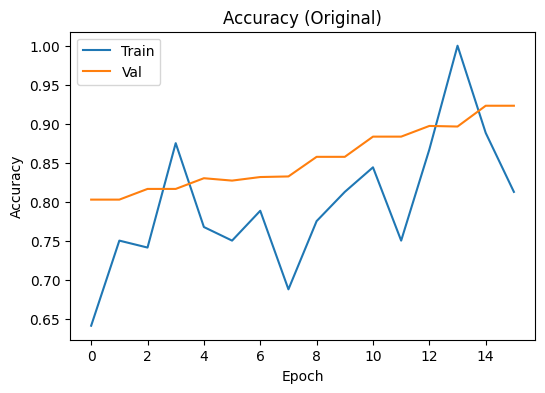

Found 4800 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 80s 236ms/step - accuracy: 0.5109 - loss: 0.8437 - val_accuracy: 0.7017 - val_loss: 0.5830
Epoch 2/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 226ms/step - accuracy: 0.6754 - loss: 0.6017 - val_accuracy: 0.7758 - val_loss: 0.4973
Epoch 3/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 220ms/step - accuracy: 0.7310 - loss: 0.5370 - val_accuracy: 0.7908 - val_loss: 0.4724
Epoch 4/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.7643 - loss: 0.4920 - val_accuracy: 0.8025 - val_loss: 0.4499
Epoch 5/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 83s 219ms/step - accuracy: 0.7749 - loss: 0.4544 - val_accuracy: 0.8092 - val_loss: 0.4456
Epoch 6/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.8006 - loss: 0.4392 - val_accuracy: 0.8125 - val_loss: 0.4321
Epoch 7/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 221ms/step - accuracy: 0.8140 - loss: 0.4084 - val_accuracy: 0.8158 - val_loss: 0.4199
Epoch 8/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 228ms/step - accuracy: 0.8131 - loss: 0.4149 - 

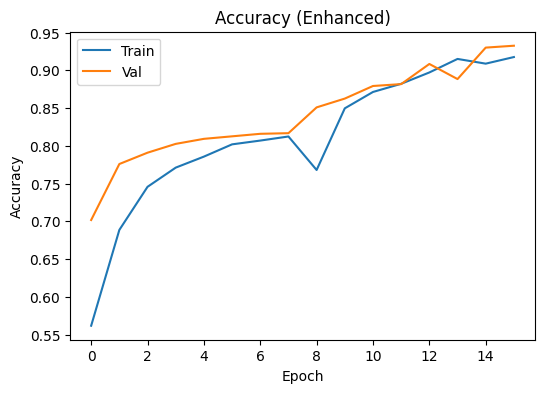

=== Original dataset ===
ROC AUC: 0.9825, AP: 0.9777
Classification Report:
              precision    recall  f1-score      support
COVID          0.964179  0.892265  0.926829   724.000000
Normal         0.880734  0.960000  0.918660   600.000000
accuracy       0.922961  0.922961  0.922961     0.922961
macro avg      0.922457  0.926133  0.922745  1324.000000
weighted avg   0.926364  0.922961  0.923127  1324.000000

=== Enhanced dataset ===
ROC AUC: 0.9872, AP: 0.9860
Classification Report:
              precision  recall  f1-score    support
COVID          0.983240  0.8800  0.928760   600.0000
Normal         0.891403  0.9850  0.935867   600.0000
accuracy       0.932500  0.9325  0.932500     0.9325
macro avg      0.937321  0.9325  0.932313  1200.0000
weighted avg   0.937321  0.9325  0.932313  1200.0000


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# --------------------------------------------------------
# Настройки
# --------------------------------------------------------
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_TOP = 8
EPOCHS_FINE = 8
LEARNING_RATE_FINE = 1e-5

# Пути к папкам с изображениями
paths = {
    "original": {
        "COVID": "/content/COVID",
        "Normal": "/content/normal"
    },
    "enhanced": {
        "COVID": "/content/enhanced_COVID",
        "Normal": "/content/enhanced_normal"
    }
}

# --------------------------------------------------------
# Функция для создания DataFrame по пути
# --------------------------------------------------------
def create_dataframe(path_dict):
    file_paths, labels = [], []
    for label_name, folder in path_dict.items():
        class_label = "COVID" if "COVID" in label_name else "Normal"
        for f in os.listdir(folder):
            if f.lower().endswith(('.png','.jpg','.jpeg')):
                file_paths.append(os.path.join(folder, f))
                labels.append(class_label)
    df = pd.DataFrame({"filename": file_paths, "class": labels})
    return df

# --------------------------------------------------------
# Модель MobileNetV2
# --------------------------------------------------------
def build_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# --------------------------------------------------------
# Функция обучения модели и возврата history и метрик
# --------------------------------------------------------
def train_model(df, title="Dataset"):
    # Split
    train_df, val_df = train_test_split(df, test_size=0.2,
                                        stratify=df['class'], random_state=42)
    # Class weights
    classes = train_df['class'].map({'COVID':0,'Normal':1}).values
    weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(classes),
                                                y=classes)
    class_weights = {0: weights[0], 1: weights[1]}

    # Генераторы
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       brightness_range=[0.7,1.3],
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(train_df,
                                                  x_col='filename',
                                                  y_col='class',
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle=True)
    val_gen = val_datagen.flow_from_dataframe(val_df,
                                              x_col='filename',
                                              y_col='class',
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode='binary',
                                              shuffle=False)

    # Обучение верхних слоев
    steps_train = len(train_df) // BATCH_SIZE
    steps_val = len(val_df) // BATCH_SIZE
    model = build_mobilenet()
    history_top = model.fit(train_gen,
                            steps_per_epoch=steps_train,
                            validation_data=val_gen,
                            validation_steps=steps_val,
                            epochs=EPOCHS_TOP,
                            class_weight=class_weights,
                            verbose=1)

    # Fine-tuning последних слоев
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:-50]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE_FINE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history_fine = model.fit(train_gen,
                             steps_per_epoch=steps_train,
                             validation_data=val_gen,
                             validation_steps=steps_val,
                             epochs=EPOCHS_FINE,
                             class_weight=class_weights,
                             verbose=1)

    # Предсказания на валидации
    val_gen.reset()
    y_true = val_gen.classes
    y_scores = model.predict(val_gen, verbose=1).ravel()
    y_pred = (y_scores > 0.5).astype(int)

    # Метрики
    report = classification_report(y_true, y_pred, target_names=["COVID","Normal"], output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_prec = average_precision_score(y_true, y_scores)

    # График обучения
    plt.figure(figsize=(6,4))
    plt.plot(history_top.history['accuracy'] + history_fine.history['accuracy'], label='Train')
    plt.plot(history_top.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val')
    plt.title(f"Accuracy ({title})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return {
        "model": model,
        "report": report,
        "cm": cm,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "avg_prec": avg_prec
    }

# --------------------------------------------------------
# 1) Обучаем на original
# --------------------------------------------------------
df_original = create_dataframe(paths['original'])
metrics_original = train_model(df_original, title="Original")

# --------------------------------------------------------
# 2) Обучаем на enhanced
# --------------------------------------------------------
df_enhanced = create_dataframe(paths['enhanced'])
metrics_enhanced = train_model(df_enhanced, title="Enhanced")

# --------------------------------------------------------
# 3) Сравнение метрик
# --------------------------------------------------------
print("=== Original dataset ===")
print(f"ROC AUC: {metrics_original['roc_auc']:.4f}, AP: {metrics_original['avg_prec']:.4f}")
print("Classification Report:")
print(pd.DataFrame(metrics_original['report']).transpose())

print("\n=== Enhanced dataset ===")
print(f"ROC AUC: {metrics_enhanced['roc_auc']:.4f}, AP: {metrics_enhanced['avg_prec']:.4f}")
print("Classification Report:")
print(pd.DataFrame(metrics_enhanced['report']).transpose())
